# Drug-Target Affinity Model Upgrade (Colab Edition)

This notebook implements the following upgrades:
1. **ESM-2 Protein Embeddings**: Replacing CNNs with a 650M parameter Language Model.
2. **Bi-Directional Cross-Attention**: Modeling interaction between Drug Graph and Protein Sequence atoms.
3. **Cold-Split Evaluation**: Rigorous testing on unseen drugs and targets.

## Colab Setup
Run the following cells to set up the environment on Google Colab.

In [ ]:
# 1. Install Dependencies
!pip install torch-geometric transformers rdkit pandas matplotlib seaborn

# Check Device
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [12]:
# 2. Mount Drive and Set Data Path
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# --- CONFIGURATION ---
# Path to your 'data' folder on Drive
DATA_DIR = '/content/drive/MyDrive/443/termproject/data'

if not os.path.exists(DATA_DIR):
    print(f"WARNING: {DATA_DIR} does not exist. Please check path.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# 3. Load and Verify Data Files
import pandas as pd

# Define file paths
DRUGS_PATH = os.path.join(DATA_DIR, "drugs.csv")
PROTEINS_PATH = os.path.join(DATA_DIR, "proteins.csv")
AFFINITY_PATH = os.path.join(DATA_DIR, "drug_protein_affinity.csv")

# Verify files exist
for path in [DRUGS_PATH, PROTEINS_PATH, AFFINITY_PATH]:
    if os.path.exists(path):
        print(f"✓ Found: {os.path.basename(path)}")
    else:
        print(f"✗ MISSING: {path}")

# Load and show basic info
print("\n--- Data Summary ---")
drugs_df = pd.read_csv(DRUGS_PATH)
proteins_df = pd.read_csv(PROTEINS_PATH)
affinity_df = pd.read_csv(AFFINITY_PATH)

print(f"Drugs: {len(drugs_df)} compounds")
print(f"Proteins: {len(proteins_df)} targets")
print(f"Affinity pairs: {len(affinity_df)} interactions")

# Preview
print("\n--- Drugs Sample ---")
print(drugs_df.head(2))
print("\n--- Proteins Sample ---")
print(proteins_df.head(2))
print("\n--- Affinity Sample ---")
print(affinity_df.head(3))

✓ Found: drugs.csv
✓ Found: proteins.csv
✓ Found: drug_protein_affinity.csv

--- Data Summary ---
Drugs: 68 compounds
Proteins: 433 targets
Affinity pairs: 29444 interactions

--- Drugs Sample ---
   Drug_Index       CID                                   Canonical_SMILES  \
0           0  11314340  CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...   
1           1  24889392  CC(C)(C)C1=CC(=NO1)NC(=O)NC2=CC=C(C=C2)C3=CN4C...   

                                     Isomeric_SMILES  
0  CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OC[C@H](CC4=C...  
1  CC(C)(C)C1=CC(=NO1)NC(=O)NC2=CC=C(C=C2)C3=CN4C...  

--- Proteins Sample ---
   Protein_Index Accession_Number                   Gene_Name  \
0              0      NP_055726.3                        AAK1   
1              1      NP_005148.2  ABL1(E255K)-phosphorylated   

                                            Sequence  
0  MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...  
1  MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...  

--- Affinity Sam

In [23]:
# 4. Utility Functions - SMILES to Molecular Graph
from rdkit import Chem
import numpy as np
from torch_geometric.data import Data

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return [x == s for s in allowable_set]

def atom_features(atom):
    """Get atom features: atomic num, degree, hydrogens (one-hot encoded)"""
    return np.array(one_of_k_encoding(atom.GetAtomicNum(), [6, 7, 8, 9, 15, 16, 17, 35, 53, 0]) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5]) +
                    one_of_k_encoding(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]), dtype=np.float32)

def smile_to_graph(smile):
    """Convert SMILES string to PyG Data object"""
    mol = Chem.MolFromSmiles(smile)
    if mol is None:
        return None

    # Node features
    num_atoms = mol.GetNumAtoms()
    features = np.array([atom_features(atom) for atom in mol.GetAtoms()])

    # Edge indices
    edges = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edges.append([i, j])
        edges.append([j, i])  # Undirected

    if len(edges) == 0:
        edge_index = torch.zeros((2, 0), dtype=torch.long)
    else:
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    x = torch.tensor(features, dtype=torch.float)

    return Data(x=x, edge_index=edge_index)

# Test it
test_smiles = drugs_df.iloc[0]['Canonical_SMILES']
test_graph = smile_to_graph(test_smiles)
print(f"Test SMILES: {test_smiles[:50]}...")
print(f"Graph: {test_graph.num_nodes} atoms, {test_graph.num_edges} bonds")

Test SMILES: CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)...
Graph: 27 atoms, 60 bonds


In [24]:
# 5. Pre-compute ESM-2 Protein Embeddings
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

# Check if embeddings already exist
EMBEDDING_PATH = os.path.join(DATA_DIR, "protein_embeddings.pt")

if os.path.exists(EMBEDDING_PATH):
    print(f"Loading existing embeddings from {EMBEDDING_PATH}...")
    protein_embeddings = torch.load(EMBEDDING_PATH)
    print(f"Loaded {len(protein_embeddings)} protein embeddings")
else:
    print("Computing ESM-2 embeddings...")

    # Load ESM-2 model (650M parameters)
    model_name = "facebook/esm2_t33_650M_UR50D"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    esm_model = AutoModel.from_pretrained(model_name).to(device)
    esm_model.eval()

    # Get unique sequences
    sequences = proteins_df['Sequence'].tolist()
    unique_seqs = list(set(sequences))
    print(f"Processing {len(unique_seqs)} unique sequences...")

    protein_embeddings = {}
    batch_size = 4  # Adjust based on GPU memory

    for i in tqdm(range(0, len(unique_seqs), batch_size)):
        batch_seqs = unique_seqs[i:i + batch_size]

        # Tokenize (truncate long sequences to 1024)
        inputs = tokenizer(batch_seqs, return_tensors="pt", padding=True,
                          truncation=True, max_length=1024)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = esm_model(**inputs)
            # Get per-residue embeddings
            embeddings = outputs.last_hidden_state.cpu()

        for seq, emb, mask in zip(batch_seqs, embeddings, inputs['attention_mask'].cpu()):
            valid_len = mask.sum().item()
            # Store as float16 to save memory
            protein_embeddings[seq] = emb[:valid_len].half()

    # Save embeddings
    torch.save(protein_embeddings, EMBEDDING_PATH)
    print(f"Saved embeddings to {EMBEDDING_PATH}")

    # Free GPU memory
    del esm_model
    torch.cuda.empty_cache()

# Verify
sample_seq = proteins_df.iloc[0]['Sequence']
print(f"\nSample embedding shape: {protein_embeddings[sample_seq].shape}")
print(f"Expected: (seq_length, 1280)")

Computing ESM-2 embeddings (this takes ~15-30 min on GPU)...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing 433 unique sequences...


100%|██████████| 109/109 [03:10<00:00,  1.75s/it]


Saved embeddings to /content/drive/MyDrive/443/termproject/data/protein_embeddings.pt

Sample embedding shape: torch.Size([963, 1280])
Expected: (seq_length, 1280)


In [25]:
# 6. GraphDTA Dataset with ESM Embeddings
from torch.utils.data import Dataset

class GraphDTADataset(Dataset):
    def __init__(self, affinity_df, drugs_df, proteins_df, embeddings, max_seq_len=1000):
        self.df = affinity_df

        # Create lookup maps
        self.drug_map = dict(zip(drugs_df['Drug_Index'], drugs_df['Canonical_SMILES']))
        self.prot_map = dict(zip(proteins_df['Protein_Index'], proteins_df['Sequence']))

        self.embeddings = embeddings
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        drug_idx = row['Drug_Index']
        prot_idx = row['Protein_Index']
        affinity = float(row['Affinity'])

        # Get SMILES and convert to graph
        smiles = self.drug_map[drug_idx]
        graph = smile_to_graph(smiles)

        # Get protein sequence and ESM embedding
        seq = self.prot_map[prot_idx]
        emb = self.embeddings[seq]  # (L, 1280)

        # Pad/truncate to max_seq_len
        L = emb.shape[0]
        if L < self.max_seq_len:
            pad = torch.zeros((self.max_seq_len - L, 1280), dtype=emb.dtype)
            emb = torch.cat([emb, pad], dim=0)
        else:
            emb = emb[:self.max_seq_len]

        graph.y = torch.tensor([affinity], dtype=torch.float)
        graph.protein_emb = emb

        return graph

# Create dataset
dataset = GraphDTADataset(affinity_df, drugs_df, proteins_df, protein_embeddings)
print(f"Dataset size: {len(dataset)} samples")

# Test one sample
sample = dataset[0]
print(f"Sample graph: {sample.num_nodes} atoms, {sample.num_edges} bonds")
print(f"Protein embedding: {sample.protein_emb.shape}")
print(f"Affinity label: {sample.y.item():.4f}")

Dataset size: 29444 samples
Sample graph: 27 atoms, 60 bonds
Protein embedding: torch.Size([1000, 1280])
Affinity label: 7.3665


In [26]:
# 7. ESM_GAT_CrossAttn Model with Bi-Directional Cross-Attention
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_max_pool
from torch_geometric.utils import to_dense_batch

class CrossAttention(nn.Module):
    def __init__(self, query_dim, key_dim, hidden_dim, num_heads=4, dropout=0.1):
        super().__init__()
        self.q_proj = nn.Linear(query_dim, hidden_dim)
        self.k_proj = nn.Linear(key_dim, hidden_dim)
        self.v_proj = nn.Linear(key_dim, hidden_dim)
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True, dropout=dropout)

    def forward(self, query, key, value, key_padding_mask=None):
        Q = self.q_proj(query)
        K = self.k_proj(key)
        V = self.v_proj(value)
        attn_out, attn_weights = self.attn(Q, K, V, key_padding_mask=key_padding_mask)
        return attn_out, attn_weights

class ESM_GAT_CrossAttn(nn.Module):
    def __init__(self, num_features_xd=21, n_output=1, esm_dim=1280,
                 hidden_dim=128, num_heads=4, dropout=0.2):
        super().__init__()

        # Drug Branch (GAT)
        self.gcn1 = GATConv(num_features_xd, num_features_xd, heads=10, dropout=dropout)
        self.gcn2 = GATConv(num_features_xd * 10, hidden_dim, dropout=dropout)
        self.fc_g1 = nn.Linear(hidden_dim, hidden_dim)

        # Protein Branch (ESM projection)
        self.esm_proj = nn.Linear(esm_dim, hidden_dim)

        # Bi-Directional Cross-Attention
        self.d2p_attn = CrossAttention(hidden_dim, hidden_dim, hidden_dim, num_heads, dropout)
        self.p2d_attn = CrossAttention(hidden_dim, hidden_dim, hidden_dim, num_heads, dropout)

        # Fusion layers
        self.fc1 = nn.Linear(hidden_dim * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.out = nn.Linear(512, n_output)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.hidden_dim = hidden_dim

    def forward(self, data, protein_emb):
        # 1. Drug Graph through GAT
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.elu(self.gcn1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.elu(self.gcn2(x, edge_index))

        # Convert to dense batch for attention
        x_drug_dense, mask_drug = to_dense_batch(x, batch)  # (B, MaxNodes, H)

        # 2. Protein through ESM projection
        x_prot = self.relu(self.esm_proj(protein_emb.float()))  # (B, SeqLen, H)
        mask_prot = (protein_emb.sum(dim=-1) != 0)  # (B, SeqLen)

        # 3. Bi-Directional Cross-Attention
        padding_mask_drug = ~mask_drug
        padding_mask_prot = ~mask_prot

        # Drug attends to Protein
        d_att, _ = self.d2p_attn(x_drug_dense, x_prot, x_prot, padding_mask_prot)
        # Protein attends to Drug
        p_att, _ = self.p2d_attn(x_prot, x_drug_dense, x_drug_dense, padding_mask_drug)

        # 4. Masked Global Max Pooling
        d_att = d_att.masked_fill(padding_mask_drug.unsqueeze(-1), float('-inf'))
        p_att = p_att.masked_fill(padding_mask_prot.unsqueeze(-1), float('-inf'))

        d_vec = torch.max(d_att, dim=1)[0]  # (B, H)
        p_vec = torch.max(p_att, dim=1)[0]  # (B, H)

        # 5. Fusion
        xc = torch.cat([d_vec, p_vec], dim=1)
        xc = self.dropout(self.relu(self.fc1(xc)))
        xc = self.dropout(self.relu(self.fc2(xc)))
        out = self.out(xc)

        return out

# Create model
model = ESM_GAT_CrossAttn(num_features_xd=21, hidden_dim=128).to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

ESM_GAT_CrossAttn(
  (gcn1): GATConv(21, 21, heads=10)
  (gcn2): GATConv(210, 128, heads=1)
  (fc_g1): Linear(in_features=128, out_features=128, bias=True)
  (esm_proj): Linear(in_features=1280, out_features=128, bias=True)
  (d2p_attn): CrossAttention(
    (q_proj): Linear(in_features=128, out_features=128, bias=True)
    (k_proj): Linear(in_features=128, out_features=128, bias=True)
    (v_proj): Linear(in_features=128, out_features=128, bias=True)
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
  )
  (p2d_attn): CrossAttention(
    (q_proj): Linear(in_features=128, out_features=128, bias=True)
    (k_proj): Linear(in_features=128, out_features=128, bias=True)
    (v_proj): Linear(in_features=128, out_features=128, bias=True)
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
  )
  (fc1): Linear(in_features=256, out_f

In [27]:
# 8. Helper Functions: Cold Splits, Metrics & Collate
from sklearn.model_selection import train_test_split
from torch_geometric.data import Batch

def get_cold_split(dataset, split_type='random', test_size=0.2, random_state=42):
    """
    Generates train/test indices based on split strategy.
    """
    df = dataset.df

    if split_type == 'random':
        indices = np.arange(len(df))
        train_idx, test_idx = train_test_split(indices, test_size=test_size, random_state=random_state)

    elif split_type == 'cold_drug':
        # Split by Drug_Index (Unseen Drugs in Test)
        unique_drugs = df['Drug_Index'].unique()
        train_drugs, test_drugs = train_test_split(unique_drugs, test_size=test_size, random_state=random_state)
        train_idx = df[df['Drug_Index'].isin(train_drugs)].index.to_numpy()
        test_idx = df[df['Drug_Index'].isin(test_drugs)].index.to_numpy()

    elif split_type == 'cold_target':
        # Split by Protein_Index (Unseen Targets in Test)
        unique_targets = df['Protein_Index'].unique()
        train_targets, test_targets = train_test_split(unique_targets, test_size=test_size, random_state=random_state)
        train_idx = df[df['Protein_Index'].isin(train_targets)].index.to_numpy()
        test_idx = df[df['Protein_Index'].isin(test_targets)].index.to_numpy()

    else:
        raise ValueError(f"Unknown split type: {split_type}")

    return train_idx, test_idx

def get_cindex(y_true, y_pred):
    """Calculate Concordance Index (CI) using PyTorch operations"""
    # Reshape
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    # Create pairs
    g = torch.sub(y_true.view(-1, 1), y_true.view(1, -1))
    g = (g > 0).float()

    f = torch.sub(y_pred.view(-1, 1), y_pred.view(1, -1))
    f = (f > 0).float()

    num = torch.sum(g * f)
    den = torch.sum(g)

    if den == 0: return 0.0
    return (num / den).item()

def custom_collate(batch):
    """
    Batches graphs and stacks protein embeddings
    """
    # 1. Batch graphs using PyG's Batch
    # PyG automatically handles standard attributes (x, edge_index, y)
    batched_graph = Batch.from_data_list(batch)

    # 2. Stack protein embeddings manually to ensure correct shape (B, L, EmbDim)
    protein_embs = [data.protein_emb for data in batch]
    batched_graph.protein_emb = torch.stack(protein_embs)

    return batched_graph

print("Helper functions defined.")

Helper functions defined.


In [28]:
# 9. Training and Evaluation Functions
from torch.utils.data import DataLoader

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for data in tqdm(loader, desc="Training", leave=False):
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass
        # data contains both graph (x, edge_index) and protein_emb
        output = model(data, data.protein_emb)

        loss = criterion(output.view(-1), data.y.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs

    return total_loss / len(loader.dataset)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0
    predictions = []
    labels = []
    criterion = nn.MSELoss()

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data, data.protein_emb)

            loss = criterion(output.view(-1), data.y.view(-1))
            total_loss += loss.item() * data.num_graphs

            predictions.append(output.view(-1))
            labels.append(data.y.view(-1))

    # Concatenate all batches
    predictions = torch.cat(predictions)
    labels = torch.cat(labels)

    mse = total_loss / len(loader.dataset)
    ci = get_cindex(labels, predictions)

    return mse, ci

print("Training loop functions defined.")

Training loop functions defined.


In [29]:
# 10. Run Experiment
from torch.utils.data import Subset

def run_experiment(split_type='random', batch_size=32, epochs=20, lr=0.0005):
    print(f"\n{'='*60}")
    print(f"Running Experiment: {split_type.upper()} SPLIT")
    print(f"{'='*60}")

    # 1. Get Split Indices
    train_idx, test_idx = get_cold_split(dataset, split_type=split_type)
    print(f"Train samples: {len(train_idx)}")
    print(f"Test samples:  {len(test_idx)}")

    # 2. Create DataLoaders
    train_set = Subset(dataset, train_idx)
    test_set = Subset(dataset, test_idx)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                              collate_fn=custom_collate)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False,
                             collate_fn=custom_collate)

    # 3. Initialize Model
    model = ESM_GAT_CrossAttn(num_features_xd=21, hidden_dim=128).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # 4. Training Loop
    best_mse = float('inf')
    best_ci = 0.0

    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_mse, val_ci = evaluate(model, test_loader, device)

        if val_mse < best_mse:
            best_mse = val_mse
            best_ci = val_ci
            # torch.save(model.state_dict(), f'best_model_{split_type}.pth')
            saved_msg = " [Saved]"
        else:
            saved_msg = ""

        print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | "
              f"Val MSE: {val_mse:.4f} | Val CI: {val_ci:.4f}{saved_msg}")

    print(f"\nFinal Result ({split_type}): Best MSE = {best_mse:.4f}, CI = {best_ci:.4f}")
    return best_mse, best_ci

# --- EXECUTE ---
# Run Random Split (Baseline)
# Note: For full training, increase epochs to 50-100
run_experiment(split_type='random', batch_size=16, epochs=10)


Running Experiment: RANDOM SPLIT
Train samples: 23555
Test samples:  5889


Epoch 01 | Train Loss: 0.9857 | Val MSE: 0.6411 | Val CI: 0.7325 [Saved]


Epoch 02 | Train Loss: 0.7450 | Val MSE: 0.6019 | Val CI: 0.7494 [Saved]


Epoch 03 | Train Loss: 0.6772 | Val MSE: 0.6163 | Val CI: 0.7571


Epoch 04 | Train Loss: 0.6444 | Val MSE: 0.5751 | Val CI: 0.7550 [Saved]


Epoch 05 | Train Loss: 0.6240 | Val MSE: 0.5388 | Val CI: 0.7816 [Saved]


Epoch 06 | Train Loss: 0.5960 | Val MSE: 0.5385 | Val CI: 0.7688 [Saved]


Epoch 07 | Train Loss: 0.5697 | Val MSE: 0.4597 | Val CI: 0.7902 [Saved]


Epoch 08 | Train Loss: 0.5596 | Val MSE: 0.5059 | Val CI: 0.7758


Epoch 09 | Train Loss: 0.5399 | Val MSE: 0.4756 | Val CI: 0.7656


Epoch 10 | Train Loss: 0.5270 | Val MSE: 0.5043 | Val CI: 0.7777

Final Result (random): Best MSE = 0.4597, CI = 0.7902


(0.4596799063012523, 0.7901775240898132)

In [30]:
# 11. Run Cold Drug Split
# Testing generalization to unseen drugs
run_experiment(split_type='cold_drug', batch_size=16, epochs=10)


Running Experiment: COLD_DRUG SPLIT
Train samples: 23382
Test samples:  6062


Epoch 01 | Train Loss: 0.9943 | Val MSE: 0.6735 | Val CI: 0.6438 [Saved]


Epoch 02 | Train Loss: 0.7337 | Val MSE: 0.8030 | Val CI: 0.6326


Epoch 03 | Train Loss: 0.6687 | Val MSE: 0.7562 | Val CI: 0.6322


Epoch 04 | Train Loss: 0.6387 | Val MSE: 0.7309 | Val CI: 0.6122


Epoch 05 | Train Loss: 0.5977 | Val MSE: 0.8061 | Val CI: 0.6405


Epoch 06 | Train Loss: 0.5740 | Val MSE: 0.6676 | Val CI: 0.6560 [Saved]


Epoch 07 | Train Loss: 0.5531 | Val MSE: 0.7617 | Val CI: 0.5773


Epoch 08 | Train Loss: 0.5321 | Val MSE: 0.7096 | Val CI: 0.5890


Epoch 09 | Train Loss: 0.5115 | Val MSE: 0.7047 | Val CI: 0.6416


Epoch 10 | Train Loss: 0.4967 | Val MSE: 0.7653 | Val CI: 0.6299

Final Result (cold_drug): Best MSE = 0.6676, CI = 0.6560


(0.667590802408514, 0.6560196280479431)

In [32]:
# 12. Run Cold Target Split
# Testing generalization to unseen protein targets
run_experiment(split_type='cold_target', batch_size=32, epochs=10)


Running Experiment: COLD_TARGET SPLIT
Train samples: 23528
Test samples:  5916


Epoch 01 | Train Loss: 1.1184 | Val MSE: 0.8412 | Val CI: 0.7165 [Saved]


Epoch 02 | Train Loss: 0.7253 | Val MSE: 0.7217 | Val CI: 0.7216 [Saved]


Epoch 03 | Train Loss: 0.6934 | Val MSE: 0.7291 | Val CI: 0.7279


Epoch 04 | Train Loss: 0.6563 | Val MSE: 0.6563 | Val CI: 0.7600 [Saved]


Epoch 05 | Train Loss: 0.6230 | Val MSE: 0.6715 | Val CI: 0.7665


Epoch 06 | Train Loss: 0.5983 | Val MSE: 0.6936 | Val CI: 0.7731


Epoch 07 | Train Loss: 0.5739 | Val MSE: 0.6193 | Val CI: 0.7798 [Saved]


Epoch 08 | Train Loss: 0.5456 | Val MSE: 0.5679 | Val CI: 0.7834 [Saved]


Epoch 09 | Train Loss: 0.5137 | Val MSE: 0.6335 | Val CI: 0.7384


Epoch 10 | Train Loss: 0.5001 | Val MSE: 0.5570 | Val CI: 0.7800 [Saved]

Final Result (cold_target): Best MSE = 0.5570, CI = 0.7800


(0.5569587963065882, 0.7800109386444092)

/tmp/ipython-input-1534981992.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_res, x='Split Type', y='CI Score', ax=ax[0], palette='viridis')
/tmp/ipython-input-1534981992.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_res, x='Split Type', y='MSE', ax=ax[1], palette='rocket')


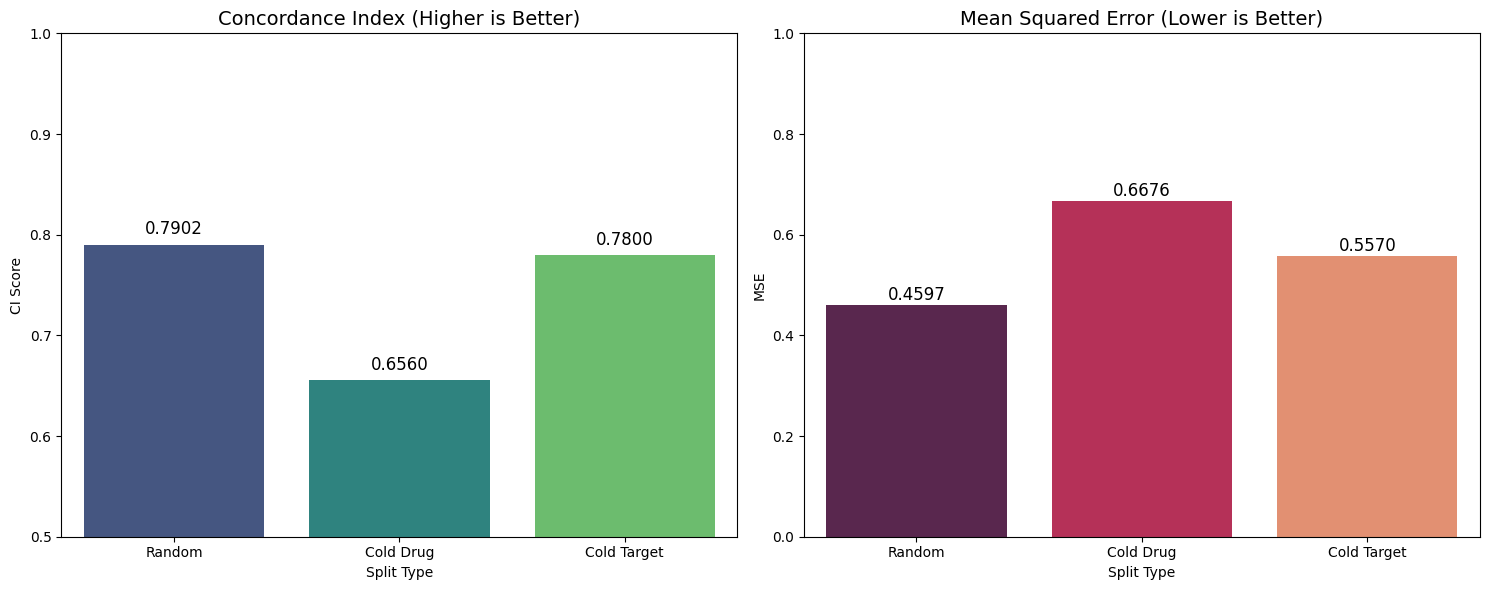

In [33]:
# 13. Plot Results
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics from our runs
results = {
    'Split Type': ['Random', 'Cold Drug', 'Cold Target'],
    'CI Score': [0.7902, 0.6560, 0.7800],
    'MSE': [0.4597, 0.6676, 0.5570]
}

df_res = pd.DataFrame(results)

# Create plots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# CI Plot
sns.barplot(data=df_res, x='Split Type', y='CI Score', ax=ax[0], palette='viridis')
ax[0].set_title('Concordance Index (Higher is Better)', fontsize=14)
ax[0].set_ylim(0.5, 1.0)
for i, v in enumerate(df_res['CI Score']):
    ax[0].text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=12)

# MSE Plot
sns.barplot(data=df_res, x='Split Type', y='MSE', ax=ax[1], palette='rocket')
ax[1].set_title('Mean Squared Error (Lower is Better)', fontsize=14)
ax[1].set_ylim(0, 1.0)
for i, v in enumerate(df_res['MSE']):
    ax[1].text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()